# Bayesian Spatiotemporal Graph Transformer Network (B-STAR) for Multi-Aircraft Trajectory Prediction

## Part 3: Testset Visualization

Author: Yutian Pang, Arizona State University

Email: yutian.pang@asu.edu

### Environment Requirements

This file is test functional with,
- Ubuntu 20.04 LTS
- Python 3.8.5 with Anaconda
- Google Cloud API key

The required packages are, 
- Pickle
- Matplotlib
- Numpy
- Bokeh 
(Note: Bokeh's GMaps function requires you to obtain and enable an Google Map Cloud API key at https://developers.google.com/maps/documentation/javascript/get-api-key)

In [ ]:
# Install Sedona(https://sedona.apache.org/)
# Refer to: https://sedona.apache.org/download/overview/#install-sedona-python
# Or install from PyPi:
! pip install pyspark shapely attrs apache-sedona

In [1]:
api_key = 'YOUR GOOGLE CLOUD API KEY HERE'

### Load Data
We only load the test data here since this document is for model testing performance visualiazation. As metioned, we have 6 days data used for training and the 1 days data for testing.

There will be two saved python dictionaries on the test data. The entire testset and the processed batch-by-batch testset. We load, and use them to test the performance of our trained deep neural network model.

- frameped_dict: 
    - dataset_index
    - frame_index
    - aircraft index list
- trajec_dict:
    - dataset_index
    - aircraft index
    - trajectories

In [2]:
import pickle

In [3]:
def load_cache(data_file):
    f = open(data_file, 'rb')
    raw_data = pickle.load(f)
    f.close()
    return raw_data
def load_dict(data_file):
    f = open(data_file, 'rb')
    raw_data = pickle.load(f)
    f.close()
    frameped_dict = raw_data[0]
    traject_dict = raw_data[1]

    return frameped_dict, traject_dict

In [4]:
# train_data_file = "test_result/train_trajectories.cpkl"
# train_batch_cache = "test_result/train_batch_cache.cpkl"
# train_frameped_dict, train_pedtraject_dict = load_dict(train_data_file)
# trainbatch, trainbatchnums, _, _ = load_cache(train_batch_cache)

test_data_file = "test_result/test_trajectories.cpkl"
test_batch_cache = "test_result/test_batch_cache.cpkl"
test_frameped_dict, test_traject_dict = load_dict(test_data_file)
testbatch, testbatchnums, _, _ = load_cache(test_batch_cache)

## Load a Pre-trained model outputs
We load a pre-trained model. During training, the best trained model is saved. The performance is evaluated using two metrics: 
- Average Displacement Error (ADE). 
- Final Displacement Error (FDE).

In this selected experiment, we have the best model when,
- The model is trained with $t_{obs}=12$, $t_{pred}=8$
- Training 300 epochs, best performance reached at epoch 290.
    - Best_ADE=0.003, Best_FDE=0.006 at Epoch 290

In [5]:
pred_batch_cache = "test_result/all_test_output_290.cpkl"
result= load_cache(pred_batch_cache)

In [6]:
print("Number of Batch in Testset: {}".format(len(testbatch)))

Number of Batch in Testset: 7


### Show Neighbors within batch of data
This is to show how is the data neighbors stored in each batch of the data. We first select the batech index in the test set. Then we plot all the neighbors in this batch(stored in binary tensor <b>nei_list_b</b> called adjacency matrix (<b>A</b>) in graph neural networks, the values 1 represents the x-y indices are neighbors. The dimension of this tensor denotes the total number of trajectories in this batch, whether they are neighbors or not). We can pick the neighbors indices to display.

In [16]:
nei_list_b.shape

(20, 258, 258)

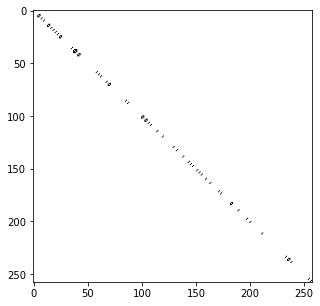

In [17]:
i_batch_number = 4
batch_data, batch_id = testbatch[i_batch_number]

nodes_batch_b, seq_list_b, nei_list_b, nei_num_b, batch_pednum = batch_data

import matplotlib.pyplot as plt 
import matplotlib.cm as cm
plt.figure(figsize=(5, 5))
plt.imshow(nei_list_b[0], cmap=cm.binary, aspect='auto')

In [18]:
nodes_batch_b.shape

(20, 258, 2)

### The neighbors (group of trajectories) selected to display
- idx_start
    - trajectory start index
- idx_end
    - trajectory end index   
    
This part is to select the index of real-neighbors in the test data to display. We visualize the adjacency matrix of the selected neighbors. In this selected neighbors below, there are three agents, each pairs of them are determined as neighbors (An agent cannot be the neighbor of itself).

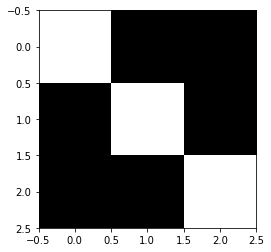

In [20]:
# idx_start = 37
# idx_end = 41

idx_start = 41
idx_end = 44

plt.imshow(nei_list_b[0][idx_start:idx_end,idx_start:idx_end],cmap=cm.binary)

# Gound Truth Visualization


### Plot the Entire Batch
This is to visualize the entire batch of the data into one plot. The timelabel is encrypted to timestamps from 1 to 20.

In [22]:
%%bash
if [ -d cache ]; 
then 
   echo "path exists"
else
   mkdir cache
fi

path exists


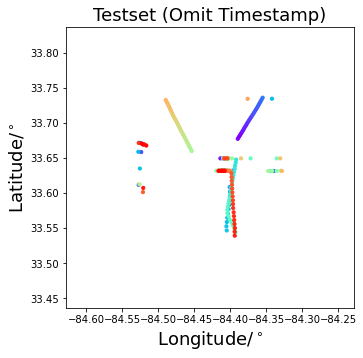

In [23]:
from IPython.display import clear_output
from matplotlib import cm
import time
import numpy as np
import time

r = 0.2
colors = cm.rainbow(np.linspace(0, 1, nodes_batch_b.shape[1]))
for i in range(20):
    clear_output(wait=True)
    fig, ax = plt.subplots(figsize=(5, 5))
    
    plt.axis([-84.4278640-r, -84.4278640+r, 33.6366996-r, 33.6366996+r])
    plt.title("Testset (Omit Timestamp)", fontsize=18)
    plt.xlabel("Longitude/$^\circ$", fontsize=18)
    plt.ylabel("Latitude/$^\circ$", fontsize=18)
    plt.subplots_adjust(left=0.17, right=0.97, top=0.9, bottom=0.12)

    plt.scatter(*nodes_batch_b[i].T, c=colors, s=10)  
    plt.savefig('cache/{}.png'.format(i), dpi=300)

    plt.show()
    #time.sleep(0.1)
    
    
buffer_groud_truth = nodes_batch_b

### Create and Save GIF
This is to create the gif file of the above animation in jupyter through Bash script. 

- jupyter bash

In [24]:
#%%bash
! (cd cache;\
convert -delay 20 -loop 0 *.png ground_truth.gif;\
find . -name "*.png" -type f -delete;\
echo "gif saved";)

^C
gif saved


## Google MAP CLOUD API
We also built an interactive geographical visualization alternative to the previous plots. We use Bokeh and the powerful Google MAP Cloud API to help us achieve this goal. This time, we plot the whole trajectory sequence instead of an animation.

In [25]:
import bokeh
from bokeh.io import output_file, show, export_png
from bokeh.models import GMapOptions
from bokeh.plotting import gmap
bokeh.io.reset_output()
bokeh.io.output_notebook()

#output_file("gmap.html")

map_options = GMapOptions(lat=33.6366996, lng=-84.4278640, map_type="hybrid", zoom=11)
p = gmap(api_key, map_options, title="KATL on Aug 7th, 2019")

for i in range(buffer_groud_truth.shape[1]):
    lat = buffer_groud_truth[:, i, 0].tolist()
    lon = buffer_groud_truth[:, i, 1].tolist()
    p.circle(x=lat, y=lon, size=5, fill_color="white", fill_alpha=0.8)
    #p.line(x=lat, y=lon, line_width=2)

show(p)

Loading BokehJS ...

In [26]:
# from selenium import webdriver

# options = webdriver.ChromeOptions()
# options.add_argument('--headless')
# options.add_argument('--no-sandbox')
# driver = webdriver.Chrome(options=options)

# p.background_fill_color = None
# p.border_fill_color = None

# export_png(p, filename="ground_truth.png")

### Plot the Selected Neighbors Data
The visualization of the neighbors set we selected above.

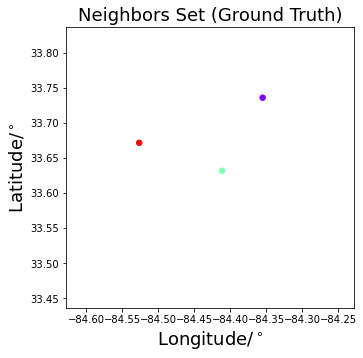

In [27]:
from IPython.display import clear_output
from matplotlib import cm
import time

buffer_groud_truth = nodes_batch_b[:,idx_start:idx_end,:]
colors = cm.rainbow(np.linspace(0, 1, buffer_groud_truth.shape[1]))

for i in range(20):
    clear_output(wait=True)
    fig, ax = plt.subplots(figsize=(5, 5))
    plt.axis([-84.4278640-r, -84.4278640+r, 33.6366996-r, 33.6366996+r])
    plt.title("Neighbors Set (Ground Truth)", fontsize=18)
    plt.xlabel("Longitude/$^\circ$", fontsize=18)
    plt.ylabel("Latitude/$^\circ$", fontsize=18)
    plt.subplots_adjust(left=0.17, right=0.97, top=0.9, bottom=0.12)

    plt.scatter(*buffer_groud_truth[i].T, c=colors, s=30)
    plt.savefig('cache/{}.png'.format(i), dpi=300)

    plt.show()
    time.sleep(0.1)

In [28]:
%%bash
cd cache 
convert -delay 20 -loop 0 *.png neighbor_set_ground_truth.gif
find . -name "*.png" -type f -delete
echo "gif saved"

gif saved


In [29]:
from bokeh.io import output_file, show
from bokeh.models import ColumnDataSource, GMapOptions
from bokeh.plotting import gmap
bokeh.io.reset_output()
bokeh.io.output_notebook()

#output_file("gmap.html")

map_options = GMapOptions(lat=33.6366996, lng=-84.4278640, map_type="roadmap", zoom=11)
p = gmap(api_key, map_options, title="KATL")

for i in range(buffer_groud_truth.shape[1]):
    lat = buffer_groud_truth[:, i, 0].tolist()
    lon = buffer_groud_truth[:, i, 1].tolist()
    p.circle(x=lat, y=lon, size=5, fill_color="red", fill_alpha=1)
    #p.line(x=lat, y=lon, line_width=2)

show(p)

Loading BokehJS ...

### The Data Feeded into B-STAR Training
In this section, we show the reader what is the actual data feeded into the B-STAR model during the training process. Simply speaking, the coordinate system is defined at origin $(x_t, y_t)$ where $t$ is the last observation timestamp. The shifting of the original data is performed at each timestamp. The function ```rotate_shift_batch``` is the implementation, which an alternative to random rotate the shifted coordinates (```ifrotate=False``` in our case). This is considered as the normalization of the inputs in standard deep learning procedures.

- Shifting is performed to the original data

In [32]:
def rotate_shift_batch(batch_data, ifrotate=True):
    '''
    Random ration and zero shifting.
    '''
    batch, seq_list, nei_list, nei_num, batch_pednum = batch_data

    # rotate batch
    if ifrotate:
        th = random.random() * np.pi
        cur_ori = batch.copy()
        batch[:, :, 0] = cur_ori[:, :, 0] * np.cos(th) - cur_ori[:, :, 1] * np.sin(th)
        batch[:, :, 1] = cur_ori[:, :, 0] * np.sin(th) + cur_ori[:, :, 1] * np.cos(th)
        
    # get shift value
    s = batch[11 - 1]

    shift_value = np.repeat(s.reshape((1, -1, 2)), 20, 0)
    batch_data = batch, batch - shift_value, shift_value, seq_list, nei_list, nei_num, batch_pednum
    return batch_data

In [33]:
batch_data_b = rotate_shift_batch(batch_data, ifrotate=False)

In [34]:
batch_abs, batch_norm, shift_value, seq_list, nei_list, nei_num, batch_pednum = batch_data_b

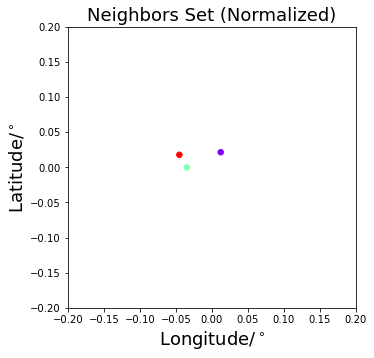

In [35]:
from IPython.display import clear_output
from matplotlib import cm
import time

buffer = batch_norm[:,idx_start:idx_end,:]
colors = cm.rainbow(np.linspace(0, 1, buffer.shape[1]))

for i in range(20):
    clear_output(wait=True)
    fig, ax = plt.subplots(figsize=(5, 5))
    plt.axis([-r, r, -r, r])
    plt.title("Neighbors Set (Normalized)", fontsize=18)
    plt.xlabel("Longitude/$^\circ$", fontsize=18)
    plt.ylabel("Latitude/$^\circ$", fontsize=18)
    plt.subplots_adjust(left=0.17, right=0.97, top=0.9, bottom=0.12)

    plt.scatter(*buffer[i].T, c=colors, s=30) 
    plt.savefig('cache/{}.png'.format(i), dpi=300)

    plt.show()

In [36]:
%%bash
cd cache 
convert -delay 20 -loop 0 *.png normalized_input.gif
find . -name "*.png" -type f -delete
echo "gif saved"

gif saved


# Test Result

### Shift the prediction back to the orginal range
We visualize the test result from the model output here, after shifting the output back to the original WGS84 coordinates.

In [37]:
shift_value.shape

(20, 258, 2)

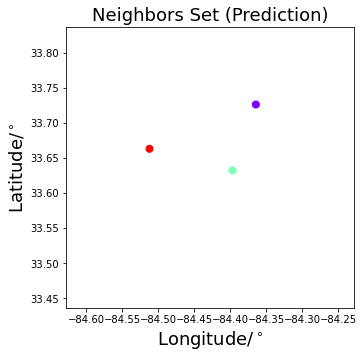

In [38]:
from IPython.display import clear_output
from matplotlib import cm
import time

buffer_pred = result['test_mean'][i_batch_number][:,idx_start:idx_end,:].cpu() + shift_value[1:,idx_start:idx_end,:]

aa = np.array(result['test_mean'][i_batch_number].cpu())
colors = cm.rainbow(np.linspace(0, 1, buffer_pred.shape[1]))

for i in range(19):
    clear_output(wait=True)
    fig, ax = plt.subplots(figsize=(5, 5))
    plt.axis([-84.4278640-r,-84.4278640+r,33.6366996-r,33.6366996+r])
    plt.title("Neighbors Set (Prediction)", fontsize=18)
    plt.xlabel("Longitude/$^\circ$", fontsize=18)
    plt.ylabel("Latitude/$^\circ$", fontsize=18)
    plt.subplots_adjust(left=0.17, right=0.97, top=0.9, bottom=0.12)

    plt.scatter(*buffer_pred[i].T, c=colors, s=50) 
    plt.savefig('cache/{}.png'.format(i), dpi=300)
    
    #plt.axis([np.min(aa[:,idx_start:idx_end,0])-1,np.max(aa[:,idx_start:idx_end,0])+1,np.min(aa[:,idx_start:idx_end,1])-1,np.max(aa[:,idx_start:idx_end,1])+1])
    plt.show()
    time.sleep(0.1)

In [39]:
%%bash
cd cache 
convert -delay 50 -loop 0 *.png prediction.gif 
find . -name "*.png" -type f -delete
echo "gif saved"

gif saved


In [40]:
from bokeh.io import output_file, show
from bokeh.models import ColumnDataSource, GMapOptions
from bokeh.plotting import gmap
bokeh.io.reset_output()
bokeh.io.output_notebook()

#output_file("gmap.html")

map_options = GMapOptions(lat=33.6366996, lng=-84.4278640, map_type="roadmap", zoom=11)
p = gmap(api_key, map_options, title="KATL")

for i in range(buffer_pred.shape[1]):
    lat = buffer_pred[:, i, 0].tolist()
    lon = buffer_pred[:, i, 1].tolist()
    p.circle(x=lat, y=lon, size=5, fill_color="red", fill_alpha=0.8, legend_label='Prediction Mean')
    #p.line(x=lat, y=lon, line_width=2)
    
    lat = buffer_groud_truth[:, i, 0].tolist()
    lon = buffer_groud_truth[:, i, 1].tolist()
    p.circle(x=lat, y=lon, size=5, fill_color="blue", fill_alpha=0.8, legend_label='Ground Truth')
    p.legend.location = "top_left"

show(p)

Loading BokehJS ...

### Prediction with Confidence Ellipse, after shifting
The model also generates the test variance on latitude and longitude dimensions. We can put a $3\sigma$ uncertainty ellipse on each prediction point. We notice that the uncertainty is minimal at the observation timestamps and keeps increasing in the predictions.

In [41]:
buffer.shape

(20, 3, 2)

In [42]:
result['test_var'][i_batch_number][:,idx_start:idx_end,:].cpu().shape

torch.Size([19, 3, 2])

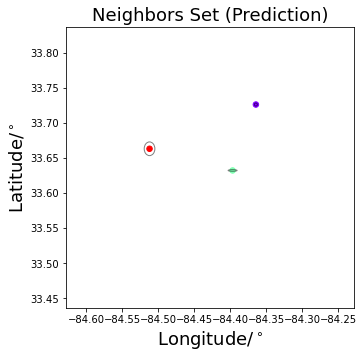

In [43]:
from IPython.display import clear_output
from matplotlib import cm
import time
from matplotlib.patches import Ellipse

mean =result['test_mean'][i_batch_number][:,idx_start:idx_end,:].cpu() + shift_value[1:,idx_start:idx_end,:]
std = np.sqrt(result['test_var'][i_batch_number][:,idx_start:idx_end,:].cpu())

aa = np.array(result['test_mean'][i_batch_number].cpu())
colors = cm.rainbow(np.linspace(0, 1, mean.shape[1]))

for i in range(19):
    clear_output(wait=True)

    fig, ax = plt.subplots(figsize=(5, 5))
    
    plt.axis([-84.4278640-r, -84.4278640+r, 33.6366996-r, 33.6366996+r])
    plt.scatter(*buffer_pred[i].T, c=colors, s=30) 
    plt.title("Neighbors Set (Prediction)", fontsize=18)
    plt.xlabel("Longitude/$^\circ$", fontsize=18)
    plt.ylabel("Latitude/$^\circ$", fontsize=18)
    plt.subplots_adjust(left=0.17, right=0.97, top=0.9, bottom=0.12)

    # draw confidence ellipse
    ells = [Ellipse(xy=[mean[i, j, 0], mean[i, j, 1]], width = 3 * std[i, j, 0], height = 3 * std[i, j, 1], 
                           angle=0, fill=False)
#                 angle=90-np.rad2deg(
#                     np.arctan((self.pred_traj_mean[idx, i, 0] - self.pred_traj_mean[idx, i-1, 0]) /
#                               (self.pred_traj_mean[idx, i, 1] - self.pred_traj_mean[idx, i-1, 1]))))
           for j in range(mean.shape[1])]
    
#     for e in ells:
#         ax.add_artist(e)
#         e.set_clip_box(ax.bbox)
#         e.set_alpha(1)
#         e.set_facecolor('r')
    
    for e in ells:
        ax.add_artist(e)
        e.set_clip_box(ax.bbox)
        e.set_alpha(0.5)
        #e.set_facecolor('b')
    
    #plt.axis([np.min(aa[:,idx_start:idx_end,0])-1,np.max(aa[:,idx_start:idx_end,0])+1,np.min(aa[:,idx_start:idx_end,1])-1,np.max(aa[:,idx_start:idx_end,1])+1])
    plt.savefig('cache/{}.png'.format(i), dpi=300)

    plt.show()
    time.sleep(0.2)

In [44]:
%%bash
cd cache 
convert -delay 20 -loop 0 *.png prediction_uq.gif
find . -name "*.png" -type f -delete
echo "gif saved"

gif saved


## Verification of Prediction Variance 
### Increasing since $t_{obs}=12$

In [45]:
t_obs = 12
t_all = 20

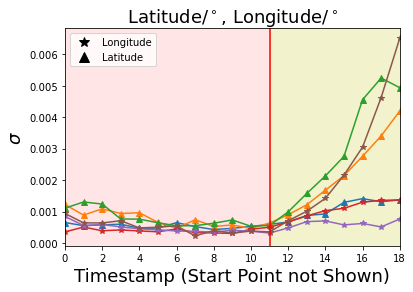

In [46]:
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

fig, ax = plt.subplots()

plt.plot(np.array(std[:, :, 0]), '-^')
plt.plot(np.array(std[:, :, 1]), '-*')

#plt.plot(np.array(result['test_var'][i_batch_number][:, idx_start:idx_end, 0].cpu()))
plt.axvline(x=t_obs-1, ymin=0, ymax=1, c='red')
ax.axvspan(0, t_obs-1, alpha=0.1, color='red')
ax.axvspan(t_obs-1, t_all-2, alpha=0.2, color='y')

plt.xlim(0, t_all-2)
plt.xlabel('Timestamp (Start Point not Shown)', fontsize=18)
plt.ylabel('$\sigma$', fontsize=18)

blue_star = mlines.Line2D([], [], color='black', marker='*', linestyle='None',
                          markersize=10, label='Longitude')
purple_triangle = mlines.Line2D([], [], color='black', marker='^', linestyle='None',
                          markersize=10, label='Latitude')
plt.legend(handles=[blue_star, purple_triangle])

plt.title('Latitude/$^\circ$, Longitude/$^\circ$', fontsize=18)

plt.savefig('std_all.png', dpi=300)

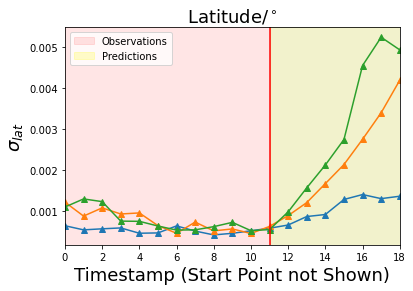

In [47]:
fig, ax = plt.subplots()

plt.plot(np.array(std[:, :, 0]), '-^')

#plt.plot(np.array(result['test_var'][i_batch_number][:, idx_start:idx_end, 0].cpu()))
plt.axvline(x=t_obs-1, ymin=0, ymax=1, c='red')
ax.axvspan(0, t_obs-1, alpha=0.1, color='red')
ax.axvspan(t_obs-1, t_all-2, alpha=0.2, color='y')

red_patch = mpatches.Patch(color='red' ,alpha=0.1, label='Observations')
blue_patch = mpatches.Patch(color='yellow', alpha=0.2, label='Predictions')
plt.legend(handles=[red_patch, blue_patch])


plt.xlim(0, t_all-2)
plt.xlabel('Timestamp (Start Point not Shown)', fontsize=18)
plt.ylabel('$\sigma_{lat}$', fontsize=18)
plt.title('Latitude/$^\circ$', fontsize=18)
plt.savefig('std_lat.png', dpi=300)

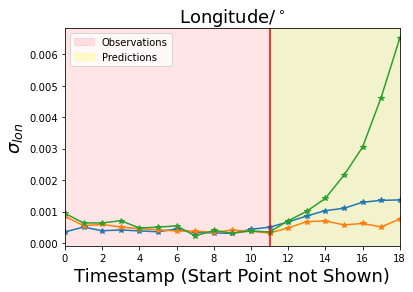

In [48]:
fig, ax = plt.subplots()
plt.plot(np.array(std[:, :, 1]), '-*')
#plt.plot(np.array(result['test_var'][i_batch_number][:, idx_start:idx_end, 0].cpu()))
plt.axvline(x=t_obs-1, ymin=0, ymax=1, c='red')
ax.axvspan(0, t_obs-1, alpha=0.1, color='red')
ax.axvspan(t_obs-1, t_all-2, alpha=0.2, color='y')

red_patch = mpatches.Patch(color='red' ,alpha=0.1, label='Observations')
blue_patch = mpatches.Patch(color='yellow', alpha=0.2, label='Predictions')
plt.legend(handles=[red_patch, blue_patch])

plt.xlim(0, t_all-2)
plt.xlabel('Timestamp (Start Point not Shown)', fontsize=18)
plt.ylabel('$\sigma_{lon}$', fontsize=18)
plt.title('Longitude/$^\circ$', fontsize=18)
plt.savefig('std_lon.png', dpi=300)

# Investigations - Sensitivity
As we mentioned, the parameters such as $t_{obs}$, $t_{pred}$ can be changed. Here we investigate the sensitivity of the propose model.

## Parametric Study on Prediction-Observation Ratio
Prediction-Observation Ratio (PO-Ratio) is simply the ratio between prediction time horizon and observation time horizon. We've got the model ADE and FDE with 5 different PO-Ratios.

In [54]:
obs_length = [12, 10, 8, 6, 4]
pred_length = [8, 10, 12, 14, 16]

ADE = [0.016, 0.016, 0.017, 0.022, 0.033]
FDE = [0.033, 0.036, 0.040, 0.049, 0.062]

ratio = [j / i for i, j in zip(obs_length, pred_length)]
ratio = [round(x, 2) for x in ratio]
ratio

[0.67, 1.0, 1.5, 2.33, 4.0]

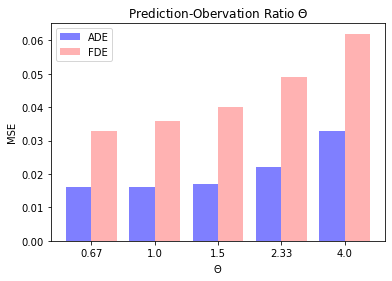

In [55]:
import numpy as np
import matplotlib.pyplot as plt

width = 0.4
plt.bar(np.arange(len(ratio)) - 0.5*width, ADE, width=width, label='ADE', color = 'blue', alpha=0.5)
plt.bar(np.arange(len(ratio)) + 0.5*width, FDE, width=width, label='FDE', color = 'red', alpha=0.3)
plt.xticks([0, 1, 2, 3, 4], ratio)
plt.xlabel('$\Theta$')
plt.ylabel('MSE')
plt.legend()
plt.title('Prediction-Obervation Ratio $\Theta$')
plt.savefig('ratio.png', dpi=300)

## Parametric Study on Neighbor Distance Threshold
The distance of two WGS84 coordinate is calculated with Havasine formula,
$d = 2R \arcsin (\sqrt{\sin^2(\frac{Y_a - Y_b}{2})+\cos(Y_a)\cos(Y_b)\sin^2(\frac{X_a - X_b}{2})})$

The threshold value (in kilometers) is used to determine the adjacency matrix mentioned above. If at a timestamp t, the coordinate distance d between two agents is lower than the threshold value, we fill the adjacency matrix with a number $1$, otherwise $0$. 

In this section, we want to study the impact of the threshold value.

In [58]:
d_threshold = [10, 20, 30]
ADE = [0.016, 0.015, 0.016]
FDE = [0.033, 0.029, 0.033]

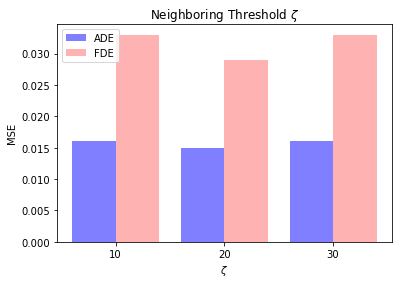

In [59]:
width = 0.4

plt.bar(np.arange(len(d_threshold)) - 0.5*width, ADE, width=width, label='ADE', color = 'blue', alpha = 0.5)
plt.bar(np.arange(len(d_threshold)) + 0.5*width, FDE, width=width, label='FDE', color = 'red', alpha = 0.3)
plt.xticks([0, 1, 2], d_threshold)
plt.xlabel('$\zeta$')
plt.ylabel('MSE')
plt.legend(loc='upper left')
plt.title('Neighboring Threshold $\zeta$')
plt.savefig('neighbor.png', dpi=300)

# Work Performed
- We developed a state-of-the-art uncertainty aware data-driven multi-agent interactive trajectory prediction model trained with real-world data.
- We verify the correctness of mean prediction, and prediction variance of the propose model using the test dataset.
- We perform sensitivity study to quantify the impact of Predictin Observation Ratio and Neighboring Threshold $\zeta$.


# Future Usage
- The propose model is suitable for any radar-based location tracking autonomous systems to perform,
    - Accurate 4D location time-series forecasting with uncertainties, 
    - Early separation violation warning system